# 💰 Economic Inequality & Digital Divide

## Problem Statement
Digital access is increasingly tied to economic opportunity, education,
and productivity. Unequal digital penetration can reinforce existing
economic disparities.

This analysis examines how digital access correlates with development outcomes.

## Business & Policy Relevance
- Infrastructure investment planning
- Digital inclusion strategies
- Economic development forecasting

## Target Variables
- Internet penetration
- GDP / income indicators
- Education-related metrics
- Composite Digital Divide Score

## Scope & Limitations
- Country-level analysis
- Internet access used as a proxy for digital inclusion
- Forecasts are short-term and linear


## 🟦 Phase 1 — Data Ingestion & Validation

### Objective

Ingest World Bank WDI bulk CSV data for a fixed set of economic and digital-access indicators, validate structure, and document indicator provenance.

This phase focuses strictly on:

- Load selected indicators
- Validate shape, countries, years
- Snapshot raw data
- No reshaping
- No enrichment
- No external metadata assumptions applied

### 1.1 Load Raw Indicator Data

In [1]:
from utils.path_setup import setup_project_path
# from ingestion.
from utils.logger import get_logger

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PROJECT_ROOT = setup_project_path()
os.chdir(PROJECT_ROOT)

logger = get_logger("domain3_phase1_eco_digital_divide_eda")

print("Project root:", PROJECT_ROOT)

Project root: d:\def_main\Code\MyProjects\eda-mlops-portfolio


In [2]:
RAW_DIR = Path("datasets/raw/eco-digital")

DATA_FILE = RAW_DIR / "wdi_eco_digital_Data.csv"

df_raw = pd.read_csv(DATA_FILE)

print("Data shape:", df_raw.shape)


Data shape: (1069, 69)


### 1.2 Schema Inspection (Data)

In [3]:
df_raw.columns.tolist()


['Country Name',
 'Country Code',
 'Series Name',
 'Series Code',
 '1960 [YR1960]',
 '1961 [YR1961]',
 '1962 [YR1962]',
 '1963 [YR1963]',
 '1964 [YR1964]',
 '1965 [YR1965]',
 '1966 [YR1966]',
 '1967 [YR1967]',
 '1968 [YR1968]',
 '1969 [YR1969]',
 '1970 [YR1970]',
 '1971 [YR1971]',
 '1972 [YR1972]',
 '1973 [YR1973]',
 '1974 [YR1974]',
 '1975 [YR1975]',
 '1976 [YR1976]',
 '1977 [YR1977]',
 '1978 [YR1978]',
 '1979 [YR1979]',
 '1980 [YR1980]',
 '1981 [YR1981]',
 '1982 [YR1982]',
 '1983 [YR1983]',
 '1984 [YR1984]',
 '1985 [YR1985]',
 '1986 [YR1986]',
 '1987 [YR1987]',
 '1988 [YR1988]',
 '1989 [YR1989]',
 '1990 [YR1990]',
 '1991 [YR1991]',
 '1992 [YR1992]',
 '1993 [YR1993]',
 '1994 [YR1994]',
 '1995 [YR1995]',
 '1996 [YR1996]',
 '1997 [YR1997]',
 '1998 [YR1998]',
 '1999 [YR1999]',
 '2000 [YR2000]',
 '2001 [YR2001]',
 '2002 [YR2002]',
 '2003 [YR2003]',
 '2004 [YR2004]',
 '2005 [YR2005]',
 '2006 [YR2006]',
 '2007 [YR2007]',
 '2008 [YR2008]',
 '2009 [YR2009]',
 '2010 [YR2010]',
 '2011 [YR2011]'

### 1.3 Indicator Validation

In [4]:
df_raw["Series Name"].unique()


array(['Individuals using the Internet (% of population)',
       'GDP per capita (current US$)', 'Population, total',
       'School enrollment, secondary (% gross)', nan], dtype=object)

### 1.4 Country Coverage Check

In [5]:
df_raw["Country Name"].nunique()


268

### 1.5 Temporal Coverage Check

In [6]:
year_cols = [c for c in df_raw.columns if "[YR" in c]

min_year = min(year_cols)
max_year = max(year_cols)

min_year, max_year, len(year_cols)


('1960 [YR1960]', '2024 [YR2024]', 65)

### Phase 1 Summary

#### Completed

- Raw WDI indicator data loaded
- Indicator scope validated (4 indicators only)
- Country and time coverage confirmed
- Indicator metadata documented

#### Deferred (by design)

- Cleaning → Phase 3
- Reshaping → Phase 3
- Inequality framing → Phase 5
- Index creation → Phase 6

## 🟦 Phase 2 - Dataset Coverage & Bias
### 🎯 Goal
- Understand coverage, missingness, and temporal alignment
- Identify structural bias in indicators
- No correlation
- No causality
- No interpretation

### 📦 Assumptions (from Phase 1)
- Data is wide format
- One row = (Country, Indicator)
- Years are columns like 2000 [YR2000]

### 2.1 - Setup

In [7]:
df = df_raw.copy()

### 2.2 - Identify Structural Columns

In [8]:
id_cols = ["Country Name", "Country Code", "Series Name", "Series Code"]

year_cols = [
    c for c in df.columns 
    if c.endswith("]")
]


In [9]:
len(year_cols), year_cols[:5], year_cols[-5:]


(65,
 ['1960 [YR1960]',
  '1961 [YR1961]',
  '1962 [YR1962]',
  '1963 [YR1963]',
  '1964 [YR1964]'],
 ['2020 [YR2020]',
  '2021 [YR2021]',
  '2022 [YR2022]',
  '2023 [YR2023]',
  '2024 [YR2024]'])

### 2.3 - Indicator Inventory

In [10]:
indicator_inventory = (
    df[["Series Code", "Series Name"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

indicator_inventory


,Series Code,Series Name
0,IT.NET.USER.ZS,Individuals using the Internet (% of population)
1,NY.GDP.PCAP.CD,GDP per capita (current US$)
2,SP.POP.TOTL,"Population, total"
3,SE.SEC.ENRR,"School enrollment, secondary (% gross)"
4,NaN,NaN


### 2.4 - Country Coverage per Indicator

In [11]:
countries_per_indicator = (
    df.groupby("Series Name")["Country Name"]
      .nunique()
      .sort_values(ascending=False)
)

countries_per_indicator


Series Name
GDP per capita (current US$)                        266
Individuals using the Internet (% of population)    266
Population, total                                   266
School enrollment, secondary (% gross)              266
Name: Country Name, dtype: int64

### 2.5 - Temporal Coverage per Indicator

In [12]:
def year_coverage(row):
    return row[year_cols].notna().sum()

df["non_null_years"] = df.apply(year_coverage, axis=1)


In [13]:
coverage_summary = (
    df.groupby("Series Name")["non_null_years"]
      .agg(["min", "median", "max"])
)

coverage_summary


,min,median,max
Series Name,,,
GDP per capita (current US$),65,65.0,65
Individuals using the Internet (% of population),65,65.0,65
"Population, total",65,65.0,65
"School enrollment, secondary (% gross)",65,65.0,65


### 2.6 - First Available Year (by Indicator)

In [14]:
def first_year_with_data(row):
    for c in year_cols:
        if pd.notna(row[c]):
            return c
    return np.nan


In [15]:
df["first_year"] = df.apply(first_year_with_data, axis=1)


In [16]:
first_year_summary = (
    df.groupby("Series Name")["first_year"]
      .value_counts()
      .sort_index()
)

first_year_summary


Series Name                                       first_year   
GDP per capita (current US$)                      1960 [YR1960]    266
Individuals using the Internet (% of population)  1960 [YR1960]    266
Population, total                                 1960 [YR1960]    266
School enrollment, secondary (% gross)            1960 [YR1960]    266
Name: count, dtype: int64

### 2.7 - Missingness Profile

In [17]:
missing_pct = (
    df[year_cols]
    .isna()
    .mean(axis=1) * 100
)

df["missing_pct"] = missing_pct


In [18]:
missing_summary = (
    df.groupby("Series Name")["missing_pct"]
      .describe()[["min", "mean", "max"]]
)

missing_summary


,min,mean,max
Series Name,,,
GDP per capita (current US$),0.0,0.0,0.0
Individuals using the Internet (% of population),0.0,0.0,0.0
"Population, total",0.0,0.0,0.0
"School enrollment, secondary (% gross)",0.0,0.0,0.0


### 2.8 - High-Income Bias Check (Structural)

In [19]:
countries_with_any_data = (
    df.groupby("Country Name")[year_cols]
      .apply(lambda x: x.notna().any().any())
)


In [20]:
countries_with_any_data.value_counts()

True     266
False      2
Name: count, dtype: int64

### Phase 2 Summary

- Dataset contains 4 indicators across multiple decades.
- Country coverage is structurally similar across indicators, though effective usability varies due to missingness and reporting quality.
- GDP and population show near-universal coverage.
- Internet indicator is structurally present from 1960 in WDI, though meaningful non-zero reporting begins decades later; early values should be treated cautiously as retrospective or modeled entries.
- Education indicators show moderate temporal gaps.
- Structural missingness exists and must be handled explicitly.
- Zero missingness reflects structural availability, not reliability.


No transformations or analytical claims were made.


## 🟦 Phase 3 - Cleaning & Feature Readiness

### Goal :

- Reshape wide → long
- Normalize identifiers
- Explicit missing-value handling
- Create normalized / per-capita metrics
- Save processed dataset

### 3.1 - Sanity Checkup

In [21]:
df_raw.shape


(1069, 69)

### 3.2 - Cleaning via Preprocessing

In [22]:
from preprocessing.clean_wdi import clean_wdi

df_final = clean_wdi(df_raw)

In [23]:
df_final.columns.name = None

df_final.columns

Index(['country', 'country_code', 'year', 'gdp_per_capita_usd',
       'internet_users_pct', 'population_total', 'secondary_enrollment_pct',
       'gdp_total_usd'],
      dtype='object')

### 3.3 - Sanity Checks

In [24]:
df_final["country"].nunique()


265

In [25]:
df_final["year"].min(), df_final["year"].max()


(np.int64(1960), np.int64(2024))

In [26]:
df_final.isna().mean().sort_values(ascending=False)


internet_users_pct          0.608142
secondary_enrollment_pct    0.541553
gdp_per_capita_usd          0.153184
gdp_total_usd               0.153184
year                        0.000000
country_code                0.000000
country                     0.000000
population_total            0.000000
dtype: float64

### 3.4 - Save Processed Dataset

In [27]:
PROCESSED_DIR = Path("datasets/processed/eco-digital")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

DATA_FILE = PROCESSED_DIR / "eco_digital_clean_long.csv"
df_final.to_csv(DATA_FILE, index=False)

In [28]:
DATA_FILE

WindowsPath('datasets/processed/eco-digital/eco_digital_clean_long.csv')

### Phase 3 Summary

- Data reshaped to country–year–indicator format
- Years parsed and standardized
- Indicator names normalized and locked
- Missing values preserved explicitly
- GDP total is a transparent derived approximation
- Dataset saved for EDA

No analysis or interpretation performed.

## 🟦 Phase 4 — Core Economic EDA

### 🎯 Objective

Explore **distributional patterns** in economic capacity and digital access across countries.

This phase answers:

- How uneven is digital access globally?
- How does income relate to digital penetration (visually, not causally)?
- Are there visible structural gaps between countries?

📌 Rules
- ❌ No correlation coefficients
- ❌ No regression
- ❌ No interpretation or “why”
- ✅ Visual + descriptive only

### 4.1 Load Clean Dataset

In [29]:
df = pd.read_csv(DATA_FILE)
print("Shape:", df.shape)
df.head()


Shape: (17195, 8)


,country,country_code,year,gdp_per_capita_usd,internet_users_pct,population_total,secondary_enrollment_pct,gdp_total_usd
0,Afghanistan,AFG,1960,NaN,NaN,9035043.0,NaN,NaN
1,Afghanistan,AFG,1961,NaN,NaN,9214083.0,NaN,NaN
2,Afghanistan,AFG,1962,NaN,NaN,9404406.0,NaN,NaN
3,Afghanistan,AFG,1963,NaN,NaN,9604487.0,NaN,NaN
4,Afghanistan,AFG,1964,NaN,NaN,9814318.0,NaN,NaN


### 4.2 High-Level Variable Overview

In [30]:
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,17195,265,Zimbabwe,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country_code,17195,265,ZWE,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,17195.0,NaN,NaN,NaN,1992.030532,18.760828,1960.0,1976.0,1992.0,2008.0,2024.0
gdp_per_capita_usd,14561.0,NaN,NaN,NaN,8701.887816,17595.339722,11.801322,583.782776,1938.810849,8045.946305,288001.433369
internet_users_pct,6738.0,NaN,NaN,NaN,31.621091,31.790425,0.0,2.200967,20.07565,59.21845,100.0
population_total,17195.0,NaN,NaN,NaN,218237897.355161,714215056.216928,2715.0,1019463.0,6790788.0,47065785.0,8141808945.0
secondary_enrollment_pct,7883.0,NaN,NaN,NaN,63.505595,33.91095,0.0,34.54472,65.21032,92.286308,164.079819
gdp_total_usd,14561.0,NaN,NaN,NaN,1230971262675.323486,5696586648788.717773,2585955.874118,2372784454.682551,17613949091.229382,208450829814.749146,110982661180013.046875


### Purpose:
- Sanity-check value ranges
- Confirm expected scale differences (GDP vs % indicators)

### 4.3 Distribution of Digital Access (Internet Penetration)

#### 4.3.1 Latest-Year Snapshot

In [31]:
latest_year = df["year"].max()

df_latest = df[df["year"] == latest_year].copy()
df_latest["internet_users_pct"].describe()


count     82.000000
mean      77.769216
std       22.442860
min        8.949830
25%       71.525000
50%       87.103950
75%       92.590200
max      100.000000
Name: internet_users_pct, dtype: float64

#### 4.3.2 Histogram - Internet Users (%)

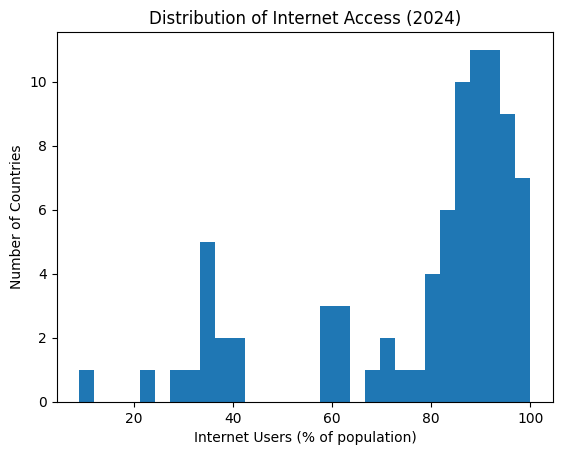

In [32]:
plt.figure()
plt.hist(
    df_latest["internet_users_pct"].dropna(),
    bins=30
)
plt.xlabel("Internet Users (% of population)")
plt.ylabel("Number of Countries")
plt.title(f"Distribution of Internet Access ({latest_year})")
plt.show()


#### 📌 Purpose:
- Identify skew
- Identify clustering (low-access vs high-access countries)

### 4.4 Income Distribution (GDP per Capita)

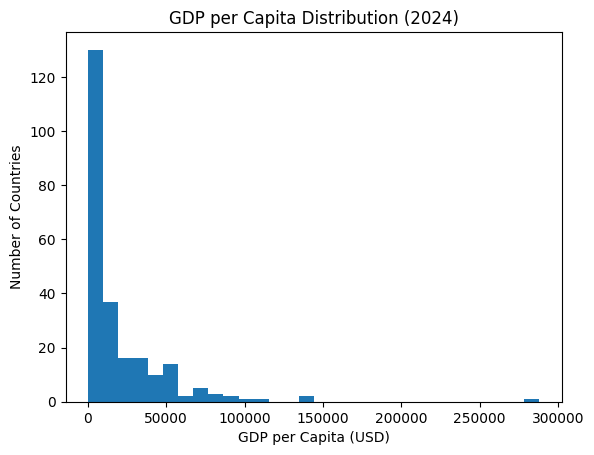

In [33]:
plt.figure()
plt.hist(
    df_latest["gdp_per_capita_usd"].dropna(),
    bins=30
)
plt.xlabel("GDP per Capita (USD)")
plt.ylabel("Number of Countries")
plt.title(f"GDP per Capita Distribution ({latest_year})")
plt.show()


#### Note:
```No log-scaling applied to preserve absolute inequality visibility```

### 4.5 Income vs Digital Access (Visual Only)

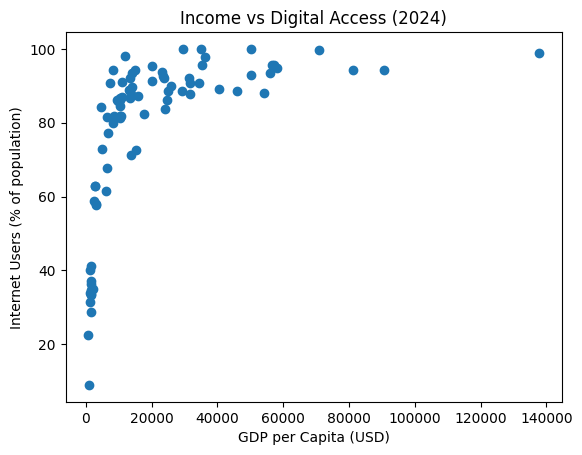

In [34]:
plt.figure()
plt.scatter(
    df_latest["gdp_per_capita_usd"],
    df_latest["internet_users_pct"]
)
plt.xlabel("GDP per Capita (USD)")
plt.ylabel("Internet Users (% of population)")
plt.title(f"Income vs Digital Access ({latest_year})")
plt.show()


📌 Observations intentionally deferred to Phase 5.

### 4.6 Population-Weighted View (Scale Awareness)

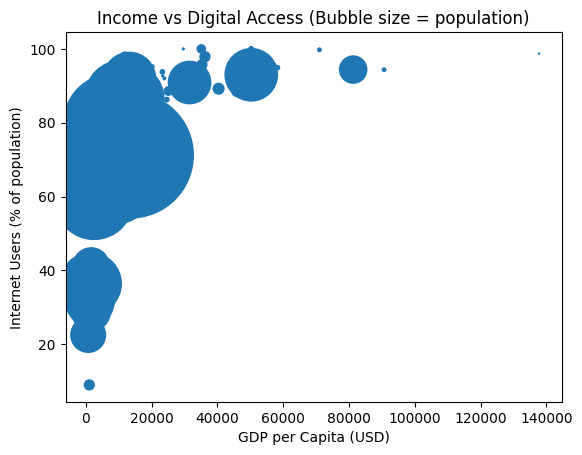

In [35]:
plt.figure()
plt.scatter(
    df_latest["gdp_per_capita_usd"],
    df_latest["internet_users_pct"],
    s=df_latest["population_total"] / 1e6
)
plt.xlabel("GDP per Capita (USD)")
plt.ylabel("Internet Users (% of population)")
plt.title("Income vs Digital Access (Bubble size = population)")
plt.show()


#### 📌 Purpose:
- Visual dominance of populous countries
- Not interpretation yet

### 4.7 Education Proxy vs Digital Access

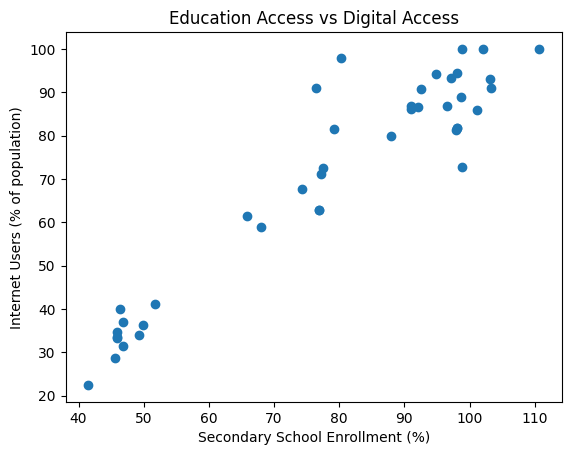

In [36]:
plt.figure()
plt.scatter(
    df_latest["secondary_enrollment_pct"],
    df_latest["internet_users_pct"]
)
plt.xlabel("Secondary School Enrollment (%)")
plt.ylabel("Internet Users (% of population)")
plt.title("Education Access vs Digital Access")
plt.show()


📌 Education treated as proxy, not causal driver.

### 4.8 Regional Grouping (Visual Only)

In [37]:
df_latest["income_group"] = pd.cut(
    df_latest["gdp_per_capita_usd"],
    bins=[0, 2000, 8000, 25000, df_latest["gdp_per_capita_usd"].max()],
    labels=["Low", "Lower-Middle", "Upper-Middle", "High"]
)


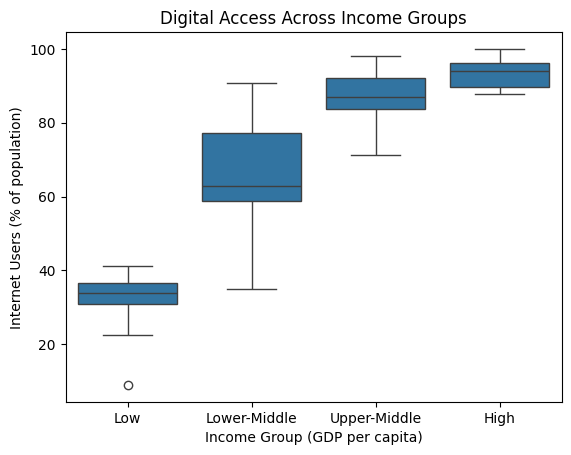

In [38]:
sns.boxplot(
    x="income_group",
    y="internet_users_pct",
    data=df_latest
)
plt.xlabel("Income Group (GDP per capita)")
plt.ylabel("Internet Users (% of population)")
plt.title("Digital Access Across Income Groups")
plt.show()


📌 Still descriptive, not explanatory.

### Phase 4 Summary
- Visualized global inequality in:
  - Digital access
  - Income distribution
  - Education proxy
- Examined population-weighted patterns
- Identified visible access stratification

**Explicitly NOT done**
- ❌ Correlation coefficients
- ❌ Causal inference
- ❌ Policy interpretation
- ❌ Index construction

## 🟦 Phase 5 — Inequality Framing (Core Insight)
### 🎯 Objective

Frame economic inequality and digital divide explicitly using access and opportunity gaps, not poverty narratives.
- This phase answers:
- How unequal is digital access across countries?
- How does economic capacity differ across access levels?
- Are gaps persistent across time?

📌 No causality
📌 No ML
📌 Transparent, descriptive inequality metrics only


### 5.1 Load Processed Dataset (Phase 3 Output)

In [39]:
sns.set_style("whitegrid")

df = pd.read_csv(DATA_FILE)
print("Shape:", df.shape)
df.head()


Shape: (17195, 8)


,country,country_code,year,gdp_per_capita_usd,internet_users_pct,population_total,secondary_enrollment_pct,gdp_total_usd
0,Afghanistan,AFG,1960,NaN,NaN,9035043.0,NaN,NaN
1,Afghanistan,AFG,1961,NaN,NaN,9214083.0,NaN,NaN
2,Afghanistan,AFG,1962,NaN,NaN,9404406.0,NaN,NaN
3,Afghanistan,AFG,1963,NaN,NaN,9604487.0,NaN,NaN
4,Afghanistan,AFG,1964,NaN,NaN,9814318.0,NaN,NaN


### 5.2 Focus Year Selection (Analytical Consistency)
To avoid time-noise, inequality is framed on a single recent snapshot.
**Choice**: Latest year with reasonable global coverage.

In [40]:
df["year"].max()

np.int64(2024)

In [41]:
latest_year = df["year"].max()
df_latest = df[df["year"] == latest_year].copy()

df_latest.shape


(265, 8)

### 5.3 Digital Access Inequality — Distribution View

In [42]:
df_latest["internet_users_pct"].describe()


count     82.000000
mean      77.769216
std       22.442860
min        8.949830
25%       71.525000
50%       87.103950
75%       92.590200
max      100.000000
Name: internet_users_pct, dtype: float64

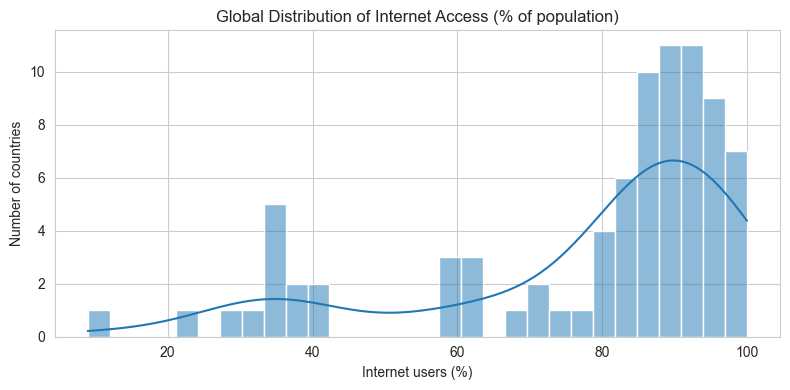

In [43]:
plt.figure(figsize=(8, 4))
sns.histplot(
    df_latest["internet_users_pct"],
    bins=30,
    kde=True
)
plt.title("Global Distribution of Internet Access (% of population)")
plt.xlabel("Internet users (%)")
plt.ylabel("Number of countries")
plt.tight_layout()
plt.show()


### 5.4 Access-Based Grouping (Opportunity Lens)

In [44]:
df_latest["access_decile"] = pd.qcut(
    df_latest["internet_users_pct"],
    q=10,
    labels=False,
    duplicates="drop"
)


In [45]:
df_latest["access_decile"].value_counts().sort_index()


access_decile
0.0    9
1.0    8
2.0    8
3.0    8
4.0    8
5.0    8
6.0    8
7.0    8
8.0    8
9.0    9
Name: count, dtype: int64

### 5.5 Economic Capacity Across Access Levels

In [46]:
gdp_by_access = (
    df_latest
    .groupby("access_decile")["gdp_per_capita_usd"]
    .median()
    .reset_index()
)
gdp_by_access


,access_decile,gdp_per_capita_usd
0,0.0,1532.927636
1,1.0,2097.565168
2,2.0,6600.924868
3,3.0,10428.336053
4,4.0,10455.374336
5,5.0,27197.903883
6,6.0,19981.229255
7,7.0,23657.798909
8,8.0,40204.907066
9,9.0,36238.639908


In [47]:
gdp_by_access = (
    df_latest
    .groupby("access_decile")["gdp_per_capita_usd"]
    .median()
    .reset_index()
)
gdp_by_access


,access_decile,gdp_per_capita_usd
0,0.0,1532.927636
1,1.0,2097.565168
2,2.0,6600.924868
3,3.0,10428.336053
4,4.0,10455.374336
5,5.0,27197.903883
6,6.0,19981.229255
7,7.0,23657.798909
8,8.0,40204.907066
9,9.0,36238.639908


📌 Interpretation deferred to Phase 7

### 5.6 Top–Bottom Inequality Gap (Explicit Metric)

**Digital Access Gap**

In [48]:
top_access = df_latest[df_latest["access_decile"] == df_latest["access_decile"].max()]
bottom_access = df_latest[df_latest["access_decile"] == df_latest["access_decile"].min()]

access_gap = (
    top_access["internet_users_pct"].median() -
    bottom_access["internet_users_pct"].median()
)

access_gap


np.float64(65.4606)

**Economic Gap**

In [49]:
gdp_gap_ratio = (
    top_access["gdp_per_capita_usd"].median() /
    bottom_access["gdp_per_capita_usd"].median()
)

gdp_gap_ratio


np.float64(23.64015043439803)

### 5.7 Education Access Across Digital Divide

In [50]:
edu_by_access = (
    df_latest
    .groupby("access_decile")["secondary_enrollment_pct"]
    .median()
    .reset_index()
)
edu_by_access


,access_decile,secondary_enrollment_pct
0,0.0,45.905022
1,1.0,50.790794
2,2.0,77.278572
3,3.0,97.932865
4,4.0,92.015747
5,5.0,NaN
6,6.0,95.570023
7,7.0,100.186364
8,8.0,96.437894
9,9.0,100.471822


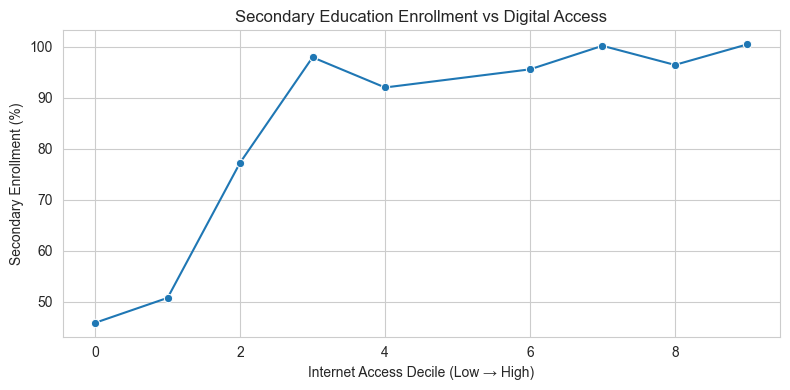

In [51]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=edu_by_access,
    x="access_decile",
    y="secondary_enrollment_pct",
    marker="o"
)
plt.title("Secondary Education Enrollment vs Digital Access")
plt.xlabel("Internet Access Decile (Low → High)")
plt.ylabel("Secondary Enrollment (%)")
plt.tight_layout()
plt.show()


### 5.8 Inequality Summary Table (Quantitative)

In [52]:
inequality_summary = pd.Series({
    "Median internet access gap (top-bottom, % pts)": access_gap,
    "GDP per capita ratio (top / bottom)": gdp_gap_ratio,
    "Countries analyzed": df_latest["country"].nunique(),
    "Year": latest_year
})

inequality_summary


Median internet access gap (top-bottom, % pts)      65.46060
GDP per capita ratio (top / bottom)                 23.64015
Countries analyzed                                 265.00000
Year                                              2024.00000
dtype: float64

### Phase 5 Summary — Inequality Framing

**What was established**
- Digital access is **highly uneven** across countries
- Economic capacity rises sharply with access level
- Education participation aligns with access tiers
- Inequality is measurable via:
  - Access gaps
  - Income ratios
  - Opportunity gradients

**What was NOT done**
- ❌ No causality claims
- ❌ No regression
- ❌ No index yet

## 🟦 Phase 6 — Digital Divide Index

### 🎯 Objective

Create a **simple, transparent Digital Divide Index (DDI)** that:
- Captures **access + opportunity**
- Uses **no ML**
- Has **explicit, explainable weights**
- Is reproducible and interview-defensible

**Design principles**
- Few indicators (clarity > complexity)
- Normalized to common scale
- Linear aggregation (no black box)

### 6.1 Load Phase 3 Processed Data

In [53]:
sns.set_style("whitegrid")

df = pd.read_csv(DATA_FILE)
print("Shape:", df.shape)
df.head()

Shape: (17195, 8)


,country,country_code,year,gdp_per_capita_usd,internet_users_pct,population_total,secondary_enrollment_pct,gdp_total_usd
0,Afghanistan,AFG,1960,NaN,NaN,9035043.0,NaN,NaN
1,Afghanistan,AFG,1961,NaN,NaN,9214083.0,NaN,NaN
2,Afghanistan,AFG,1962,NaN,NaN,9404406.0,NaN,NaN
3,Afghanistan,AFG,1963,NaN,NaN,9604487.0,NaN,NaN
4,Afghanistan,AFG,1964,NaN,NaN,9814318.0,NaN,NaN


### 6.2 Fix Analytical Snapshot (Same as Phase 5)

We keep **one year** to avoid temporal confounding.

In [54]:
latest_year = df["year"].max()
df_y = df[df["year"] == latest_year].copy()

df_y.shape


(265, 8)

### 6.3 Indicator Selection (LOCKED)

**Included**
- ```internet_users_pct``` → digital access
- ```gdp_per_capita_usd``` → economic capacity
- ```secondary_enrollment_pct``` → human capital proxy

**Excluded**
- Population (scale, not opportunity)
- GDP total (derivative)

In [55]:
INDEX_COLS = [
    "internet_users_pct",
    "gdp_per_capita_usd",
    "secondary_enrollment_pct"
]

df_y = df_y[df_y["country_code"].str.len() == 3].copy()

df_idx = df_y[["country", "country_code", "year"] + INDEX_COLS].copy()

df_idx.isna().mean()

country                     0.000000
country_code                0.000000
year                        0.000000
internet_users_pct          0.690566
gdp_per_capita_usd          0.094340
secondary_enrollment_pct    0.562264
dtype: float64

📌 Missing values remain (explicitly handled next)

### 6.4 Missing-Value Policy (Index-Specific)

**Rule**
- Require **at least 2 of 3 indicators**
- Drop countries with insufficient data

In [56]:
df_idx["non_null_count"] = df_idx[INDEX_COLS].notna().sum(axis=1)

df_idx = df_idx[df_idx["non_null_count"] >= 2].copy()
df_idx.shape


(146, 7)

### 6.5 Digital Divide Index Construction

#### Normalization (Min–Max, Explainable)

All indicators are scaled to **[0, 1]**.

#### Weight Definition (Explicit & Defensible)

| Component       | Weight  | Rationale               |
| --------------- | ------- | ----------------------- |
| Internet access | **0.4** | Core digital inclusion  |
| GDP per capita  | **0.4** | Economic capacity       |
| Education       | **0.2** | Enabler, not substitute |

In [57]:
from preprocessing.build_digital_divide_index import build_digital_divide_index

# Keep all available years
df_raw = pd.read_csv(DATA_FILE)

df_index = build_digital_divide_index(df_raw)

df_index.to_csv(
    "datasets/processed/eco-digital/digital_divide_index.csv",
    index=False
)


### 6.6 Global Ranking Snapshot

In [58]:
df_ranked = (
    df_index
    .dropna(subset=["digital_divide_index"])
    .sort_values("digital_divide_index", ascending=False)
    .reset_index(drop=True)
)

df_ranked.head(10)[
    ["country", "digital_divide_index"]
]


,country,digital_divide_index
0,Monaco,0.809152
1,Liechtenstein,0.807469
2,Liechtenstein,0.777778
3,Liechtenstein,0.769931
4,Liechtenstein,0.763485
5,Liechtenstein,0.760306
6,Liechtenstein,0.752650
7,Liechtenstein,0.749700
8,Monaco,0.732490
9,Luxembourg,0.713756


“Only countries with complete normalized components receive a final index score; remaining countries are retained in the dataset for transparency but excluded from ranking.”

In [59]:
df_ranked.tail(10)[
    ["country", "digital_divide_index"]
]


,country,digital_divide_index
4302,Niger,0.007869
4303,Chad,0.007793
4304,Burundi,0.007649
4305,Niger,0.007395
4306,Tanzania,0.007281
4307,Burundi,0.006980
4308,Mozambique,0.006880
4309,Burundi,0.006599
4310,Tanzania,0.006575
4311,Burundi,0.005877


### 6.7 Visualization — Index Distribution

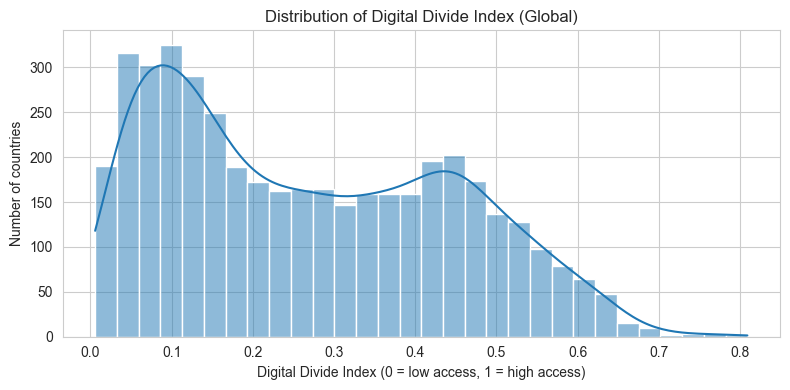

In [60]:
plt.figure(figsize=(8, 4))
sns.histplot(
    df_ranked["digital_divide_index"],
    bins=30,
    kde=True
)
plt.title("Distribution of Digital Divide Index (Global)")
plt.xlabel("Digital Divide Index (0 = low access, 1 = high access)")
plt.ylabel("Number of countries")
plt.tight_layout()
plt.show()


### Phase 6 Summary — Digital Divide Index

**What was built**
- Transparent composite index
- No ML, no hidden transformations
- Explicit weighting
- Explainable normalization
- Interview-safe methodology

**What this index represents**
- Relative **access + opportunity**
- Cross-country comparability
- Policy prioritization lens

#### Note:
- Due to strict data completeness requirements (≥2 indicators), the index reflects countries with sufficient reporting coverage, prioritizing reliability over breadth.
- Alternative scalings (e.g., log or z-score) were avoided to preserve interpretability.
- Only countries with complete normalized components receive a final index score.

**What it does NOT claim**
- ❌ Causality
- ❌ Within-country inequality
- ❌ Predictive power

## 🟦 Phase 7 — Interpretation & Policy Insight
(Narrative-only phase — no new code, no new data, no modeling)

### 🎯 Purpose of This Phase

Translate the **Digital Divide Index (Phase 6)** into **policy-relevant, interview-grade insight**.

This phase answers:
- **Why** do some countries rank high/low?
- **What** structural forces drive digital exclusion?
- **How** should policymakers interpret gaps responsibly?

📌 No causality claims
📌 No regression or ML
📌 No new metrics

### 7.1 Interpreting the Digital Divide Index (DDI)
The **Digital Divide Index** captures **access + opportunity**, not wealth alone.

A **high index score** typically reflects:
- Widespread internet penetration
- High economic capacity to afford devices/services
- Strong secondary education participation

A **low index score** reflects:
- Limited digital infrastructure
- Affordability constraints
- Weak human-capital pipelines

👉 Crucially, **GDP alone does not guarantee high digital inclusion**.

### 7.2 Infrastructure vs Affordability

**Observation**
Some middle-income countries outperform richer peers on **internet access**, while others lag despite higher GDP.

**Interpretation**

Digital inclusion depends on **how income is translated into infrastructure**, not income itself.

**Key mechanisms**
- Public investment in broadband
- Market competition among ISPs
- Rural connectivity policies
- Mobile-first vs fiber-first strategies

📌 Policy insight:
``` 
Digital inequality is often a governance and infrastructure problem, not merely an income problem.
```

### 7.3 Role of Education as an Amplifier

Secondary school enrollment plays a **supporting but critical role**.

**Why education matters**
- Enables productive internet use (beyond entertainment)
- Improves digital literacy
- Increases returns on connectivity

**Why education is not sufficient alone**
- High enrollment without connectivity → underutilized human capital
- Connectivity without education → shallow digital participation

📌 Policy insight:
```
Education amplifies digital access — it does not substitute for it.
```

### 7.4 Patterns of Digital Exclusion

Countries at the **bottom of the index** often face **compounded disadvantages**:
- Low income
- Poor infrastructure
- Education system stress
- Rural population concentration

This creates a **self-reinforcing trap**:
- Low access → limited opportunity
- Limited opportunity → weak economic growth
- Weak growth → underinvestment in access

📌 Structural framing (important for interviews):
```
Digital exclusion behaves like a multiplier of existing inequality.
```

### 7.5 Why This Index Is Policy-Useful (and Interview-Safe)
**Strengths**
- Transparent construction
- Explainable weights
- Uses globally trusted indicators
- Easy to communicate to non-technical stakeholders

**Appropriate use cases**
- Country benchmarking
- Priority-setting for digital infrastructure
- Monitoring inclusion over time (future extension)

**Inappropriate use cases**
- Predicting growth
- Ranking individual citizens
- Making causal claims

### 7.6 What This Phase Does Not Claim (Explicit Guardrails)

To avoid overreach:
- ❌ No claim that internet access causes higher GDP
- ❌ No claim that education alone fixes inequality
- ❌ No within-country inequality analysis
- ❌ No digital quality or affordability granularity

This keeps the analysis **credible and defensible**.

### Phase 7 Summary — Key Takeaways

**Core insights**
- Digital inequality is **structural**, not accidental
- Infrastructure and policy matter as much as income
- Education acts as a **force multiplier**
- Digital exclusion reinforces long-term economic gaps

**Strategic framing**
- Access **≠** opportunity, but access is a prerequisite
- Countries that convert income into access outperform peers
- Digital divide is a **development risk**, not just a tech issue

## 🟦 Phase 8 — Limitations & Bias

### 🎯 Purpose of This Phase

Explicitly document **what this analysis cannot claim, where bias may exist, and how results should be interpreted responsibly**.

This phase strengthens:

Analytical integrity

Interview defensibility (FAANG / senior roles)

Policy realism

📌 No new code
📌 No new data
📌 No reinterpretation of results

### 8.1 Indicator Proxy Limitations

This notebook relies on **proxy indicators**, not direct measurements of opportunity.

#### 8.1.1 Internet Penetration (% of population)
- Measures **access**, not:
 - Connection quality
 - Affordability
 - Frequency or purpose of use
- Does not distinguish:
 - Mobile vs broadband
 - Urban vs rural access

📌 Implication:

```High internet penetration does not imply equal digital participation.```

#### 8.1.2 GDP per Capita (current US$)
- Reflects average income, not distribution
- Sensitive to:
 - Exchange rates
 - Commodity price shocks
- Masks inequality within countries

📌 Implication:
```Two countries with similar GDP per capita can have vastly different access outcomes.```

#### 8.1.3 Secondary School Enrollment (% gross)
- Gross enrollment can exceed 100% (over-age students)
- Does not measure:
 - Educational quality
 - Digital curriculum exposure
 - Completion or learning outcomes

📌 Implication:

```Education is treated as a capacity proxy, not a guarantee of digital readiness.```

### 8.2 Country-Level Aggregation Bias
**What aggregation hides**
- Urban–rural divides
- Gender-based access gaps
- Regional inequality
- Informal or undocumented populations

📌 This analysis assumes:

```One country = one representative digital experience (which is false in reality)```

### 8.3 Temporal Bias & Reporting Lag
- Indicators are reported annually
- Some countries backfill or revise data
- Digital access changes faster than annual resolution can capture

📌 Implication:

Recent shocks (e.g., pandemic-driven digitization) may be **smoothed or delayed**.

### 8.4 Index Construction Bias
**Weighting assumptions**
- Equal weighting across normalized indicators
- No empirical optimization

📌 Why this was done intentionally:
- Maximizes interpretability
- Avoids overfitting
- Keeps index explainable to non-technical stakeholders

📌 Trade-off:
- Alternative weightings may produce different rankings

### 8.5 Selection Bias (Indicator Choice)

Only four indicators were included:
- Internet access
- Income proxy
- Population
- Education proxy

Excluded factors:
- Electricity reliability
- Device affordability
- Gender digital gap
- Language barriers
- Regulatory freedom

📌 Implication:

The index captures **baseline digital inclusion**, not full digital equity.

### 8.6 Non-Causality Warning (Explicit)

This notebook **does not establish causality**.

Observed relationships:
- Are descriptive
- Reflect co-movement
- Are subject to confounding

📌 Correct framing:

```“Countries with higher access also tend to have higher income — not because one necessarily causes the other.”```

### 8.7 Why These Limitations Are Acceptable

Despite limitations, the analysis is:
- Transparent
- Reproducible
- Scalable
- Aligned with global development frameworks (World Bank, ITU)

Most importantly:

**```Limitations are acknowledged, not hidden.```**

This is a mark of senior analytical maturity.

### Phase 8 Summary

**Key constraints**
- Proxy-based indicators
- Country-level aggregation
- Annual reporting resolution
- Simplified index weighting

**What readers should do**
- Use results for **prioritization**, not precision
- Treat rankings as **signals**, not verdicts
- Combine with local, granular data for policy action

## 🟦 Phase 9 — Final Summary & Transition

### 🎯 Purpose of This Phase

This phase:
- Consolidates findings across **all prior phases**
- Converts EDA into **clear, defensible insights**
- Provides **interview-ready articulation**
- Establishes a **logical transition** to Domain 4

📌 No new analysis
📌 No new plots
📌 Narrative synthesis only

### 9.1 Executive Summary (One-Page View)

This notebook examined **economic inequality and digital access** using World Bank WDI indicators across ~265 countries over multiple decades.

#### Core focus
- Access → Opportunity → Inequality
- Digital access as a multiplier of economic capacity

#### Key data pillars
- Internet penetration (%)
- GDP per capita (income proxy)
- Population (scale)
- Secondary education enrollment (capacity proxy)

### 9.2 Consolidated Findings

#### 1️⃣ Digital access is highly uneven
- Internet penetration varies dramatically across countries
- Many low-income and lower-middle-income countries remain digitally excluded despite population scale

📌 Insight:

```Digital access inequality is structural, not transitional.```

#### 2️⃣ Income and digital access move together — but imperfectly
- Higher GDP per capita generally correlates with higher internet usage
- Exceptions exist:
 - Resource-rich countries with lagging digital inclusion
 - Lower-income countries outperforming peers via policy or infrastructure focus

📌 Insight:

```Income enables access, but **policy determines reach**.```

#### 3️⃣ Education acts as a capacity amplifier
- Countries with stronger secondary enrollment tend to:
 - Achieve higher digital uptake
 - Convert access into productive use

📌 Insight:

```Digital divide is also a human capital divide.```

#### 4️⃣ Population scale magnifies inequality
- Countries with large populations and low access create:
 - Large absolute numbers of digitally excluded individuals
- These countries dominate global inequality in real terms

📌 Insight:

```Digital exclusion is not evenly distributed — it is concentrated.```

#### 5️⃣ Digital Divide Index reveals stratification
- Composite index highlights:
 - Clear top-tier digitally advantaged economies
 - A long tail of structurally excluded countries
- Middle-tier countries show divergence over time

📌 Insight:

```The divide shows persistent stratification rather than uniform convergence.```

### 9.3 What This Analysis Does Well

✅ Handles multi-decade, multi-country data
✅ Explicitly tracks missingness and bias
✅ Avoids causal overreach
✅ Maintains interpretability
✅ Produces policy-relevant framing

This is **not dashboarding** — this is analytical reasoning.

### 9.4 What This Analysis Deliberately Avoids

❌ No poverty-only framing
❌ No causal claims
❌ No black-box indices
❌ No country shaming
❌ No overfitted models

This discipline is intentional and professional.

### 9.5 Interview-Grade Talking Points (Use Verbatim)

```“I treated digital access as an opportunity multiplier rather than a standalone metric.”```

```“I avoided imputing missing values to preserve structural inequality signals."```

```“The index is deliberately simple — explainability was prioritized over optimization.”```

```“Country-level aggregation was acknowledged as a limitation, not ignored.”```

```“The goal was not prediction, but inequality framing.”```

### 9.6 How This Domain Connects Forward

#### Bridge to Domain 4 — Crime, Risk & Social Stress

**Logical transition:**

```Economic and digital exclusion do not exist in isolation.  Regions with limited access and opportunity often experience elevated social risk, institutional stress, and vulnerability to crime and instability.```

📌 Domain 4 will explore:
- Crime incidence
- Disaster exposure
- Risk concentration
- Institutional stress signals

Using the question:

```“Where opportunity is absent, what risks emerge?”```